In [1]:
import numpy as np 
import pandas as pd 
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge, Lasso, LinearRegression
from sklearn.svm import SVR
import json
from src.metric_participants import ComputeMetrics, base_metric
from pandasql import sqldf
from typing import Tuple, Dict, List
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import sys
from datetime import datetime

makeQuery = lambda q: sqldf(q, globals())

In [2]:
referenceDate = datetime.strptime('2020-07', '%Y-%m')
salesOffset = 100
sales = pd.read_csv('./data/data_files/sales_train_splitted.csv', index_col=0)

regions = ['region_{}'.format(i) for i in range(201)]
months = list([datetime.strptime(m, '%Y-%m') for m in set(sales.month.values.tolist())])
months.sort()
months = ['{}-{}'.format(d.year, '0'+str(d.month) if d.month < 10 else d.month) for d in months]
brands = ['brand_1', 'brand_2']

In [26]:
def sortDf(df: pd.DataFrame, isTrain: bool) -> pd.DataFrame: 
    tempRegions = regions[:151] if isTrain else regions[151:]
    df.region = pd.Categorical(df.region, tempRegions)
    df.month = pd.Categorical(df.month, months)
    df.sort_values(['region', 'month'], inplace=True)
    df.reset_index(drop=True, inplace=True)
    return df


def loadRegionData(isTrain: bool) -> Dict[str, pd.DataFrame]: 
    """
    Return a dict of data for each brand
    """
    features = {brand: pd.read_csv('./data/data_files/region_features/{}_{}.csv'.format('training' if isTrain else 'test', brand), index_col=0) for brand in brands}
    return features


def loadTimeData(isTrain: bool) -> Dict[str, pd.DataFrame]: 
    """
    Return a dict of data for each brand
    """
    timeData = {}
    for brand in brands: 
        df = pd.read_csv('./data/data_files/time_features/time_features_{}_{}.csv'.format(brand, 'train' if isTrain else 'test'), index_col=0)
        df = df[df['month'].apply(filterMonths)]
        sortDf(df, isTrain)
        timeData[brand] = df
    return timeData


def mergeTimeAndEstimatedData(estimations: pd.DataFrame, timeData: Dict[str, pd.DataFrame]) -> Dict[str, pd.DataFrame]: 
    trainingsData = {}
    for brand in brands: 
        df = pd.concat([estimations[estimations['brand'] == brand].reset_index(drop=True), 
                      timeData[brand].drop(['month', 'region'], axis=1)], axis=1)
        df.drop('brand', axis=1, inplace=True)
        df.rename(columns={'sales': 'sales_estimate'}, inplace=True)
        trainingsData[brand] = df
    return trainingsData
    
    
def loadSalesData(isTrain: bool) -> pd.DataFrame: 
    return pd.read_csv('./data/data_files/sales_{}_splitted.csv'.format('train' if isTrain else 'test'), index_col=0)


def prepareRegionYTrue(salesDf: pd.DataFrame) -> Dict[str, pd.DataFrame]:
    # split by brand and transform time data to columns
    transformedData = {}
    for brand in brands: 
        brandData = {}
        for month in months: 
            query = """
            SELECT region, sales
            FROM sales
            WHERE brand = '{brand}'
            AND month = '{month}'
            """.format(brand=brand, month=month)
            df = makeQuery(query)
            df.set_index('region', drop=True, inplace=True)
            brandData[month] = df['sales'].to_dict()
        df = pd.DataFrame.from_dict(brandData, orient='index').sort_index(ascending=True).T
        transformedData[brand] = pd.DataFrame(np.where((df == 0), sys.float_info.epsilon, df.values), index=df.index, columns=df.columns)
    return transformedData
    

def prepareTimeYTrue(sales: pd.DataFrame) -> Dict[str, pd.DataFrame]: 
    """
    Return a dict of data for each brand
    """
    brandSplitted = {}
    for brand in brands: 
        df = sales[sales['brand'] == brand]
        df = df[df['month'].apply(filterMonths)]
        df.reset_index(drop=True, inplace=True)
        brandSplitted[brand] = df
    return brandSplitted
    
    
def prepareEstimateYTrue(transformedData: Dict[str, pd.DataFrame]) -> Dict[str, pd.DataFrame]: 
    # fit a linear model on each region -> parameters are target values for prediction model
    linearModels = {}
    failedModels = []
    initialGuesses = []
    for brand in brands: 
        # df = transformedData[brand].applymap(lambda x: np.log10(x) if x > 0 else 0)
        df = transformedData[brand]
        regionParameters = {}
        x = np.arange(6, df.shape[1]) # start at july
        for i, row in df.iterrows(): 
            # k, d = np.polyfit(x, row.values[6:], deg=1)
            # regionParameters[i] = {'k': k, 'd': d}
            #make initial guess
            y = row.values[6: ]
            initialGuess = [max(y), np.median(x),1,min(y)] 
            initialGuesses.append(initialGuess)
            bounds = (np.array(initialGuess)/2, np.array(initialGuess)*2)
            try: 
                fittedParams = curve_fit(func, x, y, initialGuess, method='dogbox', maxfev=10000, bounds=bounds)[0]
            except RuntimeError as e: 
                print(i, e)
                fittedParams = initialGuess
                failedModels.append(i)
            regionParameters[i] = {i: p for i, p in enumerate(fittedParams)}
        linearModels[brand] = pd.DataFrame.from_dict(regionParameters, orient='index')
    return linearModels
    
    
def func(x, L ,x0, k, b):
    # code for fitting this curve was found here: https://stackoverflow.com/questions/55725139/fit-sigmoid-function-s-shape-curve-to-data-using-python
    y = L / (1 + np.exp(-k*(x-x0)))+b
    return (y)


def predictSales(x, *params): 
    predictedSales = func(x, *params)
    return np.where(predictedSales < salesOffset, 0, predictedSales)  # consider these values 0


def makeSubmissionDataFromEstimates(predictions: Dict[str, pd.DataFrame], isTrain: bool) -> pd.DataFrame:
    submissionData = []
    tempRegions = regions[:151] if isTrain else regions[151:]
    for brand in brands: 
        preds = predictions[brand]
        preds.rename(columns={c: months[c+6] for c in preds.columns}, inplace=True)
        for month in months[6:]: 
            for region in tempRegions: 
                row = [region, month, brand, preds.at[region, month]]
                submissionData.append(row)
    submissionData = pd.DataFrame(submissionData, columns=['region', 'month', 'brand', 'sales'])
    sortDf(submissionData, isTrain)
    return submissionData


def trainEstimationModel(xTrain: Dict[str, pd.DataFrame], 
                         yTrain: Dict[str, pd.DataFrame], 
                         modelClass, 
                         modelParams,
                        ):
    """
    Returns dicts containing the fitted models, the scalers for each brand.
    """
    models, scalers = {}, {}
    for brand in brands: 
        currentX = xTrain[brand].values
        currentY = yTrain[brand].values
        
        scaler = StandardScaler()
        xTrainScaled = scaler.fit_transform(currentX)
        
        model = modelClass(**modelParams)
        model.fit(xTrainScaled, currentY)
        
        models[brand] = model
        scalers[brand] = scaler
    return models, scalers


def predictEstimationModel(x: Dict[str, pd.DataFrame], models, scalers, ): 
    monthsToPredict = np.arange(6, len(months))
    predictions = {}
    for brand in brands: 
        
        scaler = scalers[brand]
        model = models[brand]
        xScaled = scaler.transform(x[brand].values)
    
        parameters = model.predict(xScaled)
        predictedSales = []
        for params in parameters: 
            salesForecasts = predictSales(monthsToPredict, *params)
            predictedSales.append(salesForecasts)
        predictedSales = pd.DataFrame(predictedSales, index=x[brand].index)
        predictions[brand] = predictedSales
    return predictions


#def getCIFromEstimationModel(xTest: Dict[str, pd.DataFrame], models): 
#    predictions = []
#    x = xTest[brand]
#    model = models[brand]
#    for _clf in model.estimators_: 
#        yPred = _clf.predict(x.values[:, 2:])
#        predictions.append(yPred.reshape(-1, 1))
#    predictions = np.concatenate(predictions, axis=1)
#    lower = pd.DataFrame(np.percentile(predictions, 20, axis=1), index=x.index, columns=['lower'])
#    upper = pd.DataFrame(np.percentile(predictions, 80, axis=1), index=x.index, columns=['upper'])
#    return pd.concat([lower, upper], axis=1)


def filterBrands(x): 
    return x in ['brand_1', 'brand_2']


def filterMonths(x): 
    d = datetime.strptime(x, '%Y-%m')
    return d >= referenceDate


def trainCorrectionModel(xTrain: Dict[str, pd.DataFrame], 
                         yTrain: Dict[str, pd.DataFrame], 
                         modelType, 
                         modelParams): 
    models = {}
    for brand in brands: 
        x = xTrain[brand].values[:, 2:]
        y = yTrain[brand]['sales'].values
        
        model = modelType(**modelParams)
        model.fit(x, y)
        models[brand] = model
    return models


def predictCorrectionModel(xTest: Dict[str, pd.DataFrame], models) -> Dict[str, pd.DataFrame]:
    predictions = {}
    for brand in brands: 
        x = xTest[brand]
        model = models[brand]
        yPred = model.predict(x.values[:, 2:])  # remove month and region
        yPred = pd.DataFrame(yPred, columns=['sales'], index=x.index)
        yPred = pd.concat([x[['region', 'month']], yPred], axis=1)
        predictions[brand] = yPred
    return predictions


def getCIFromCorrectionModel(xTest: Dict[str, pd.DataFrame], models) -> Dict[str, pd.DataFrame]: 
    ciBounds = {}
    for brand in brands: 
        predictions = []
        x = xTest[brand]
        model = models[brand]
        for _clf in model.estimators_: 
            yPred = _clf.predict(x.values[:, 2:])
            predictions.append(yPred.reshape(-1, 1))
        predictions = np.concatenate(predictions, axis=1)
        lower = pd.DataFrame(np.percentile(predictions, 20, axis=1), index=x.index, columns=['lower'])
        upper = pd.DataFrame(np.percentile(predictions, 80, axis=1), index=x.index, columns=['upper'])
        ciBounds[brand] = pd.concat([lower, upper], axis=1)
    return ciBounds


def makeCorrectionSubmissionData(predictions: Dict[str, pd.DataFrame], 
                                 ciBounds: Dict[str, pd.DataFrame], 
                                 isTrain: bool = False) -> pd.DataFrame: 
    submissionData = []
    for brand in brands: 
        df = pd.concat([predictions[brand], ciBounds[brand]], axis=1)
        df['brand'] = brand
        submissionData.append(df)
    submissionData = pd.concat(submissionData, axis=0)
    sortDf(submissionData, isTrain)
    submissionData['lower'] = np.min(submissionData[['sales', 'lower']].values, axis=1)
    submissionData['upper'] = np.max(submissionData[['sales', 'upper']].values, axis=1)
    return submissionData


def plotRandomRegions(submissionData: pd.DataFrame, 
                      brand: str, 
                      isTrain: bool = False, 
                      groundTruth: pd.DataFrame = None
                     ): 
    fig, ax = plt.subplots(nrows=4, ncols=4, figsize=(8, 8), sharex=True)
    for i in range(4): 
        for j in range(4): 
            if isTrain: 
                randomRegion = 'region_{}'.format(np.random.randint(151))
            else: 
                randomRegion = 'region_{}'.format(np.random.randint(151, 201, 1)[0])
            df = submissionData[submissionData['brand'] == brand]
            df = df[df['region'] == randomRegion]
            sales, lower, upper = df['sales'].values, df['lower'].values, df['upper'].values
            ax[i, j].plot(df['month'].values, sales, 'r--')
            ax[i, j].plot(df['month'].values, lower, 'b--')
            ax[i, j].plot(df['month'].values, upper, 'b--')
            
            if groundTruth is not None: 
                df = groundTruth[groundTruth['brand'] == brand]
                df = df[df['region'] == randomRegion]
                ax[i, j].plot(df['month'].values, df['sales'].values, 'g--')
            
    plt.setp(ax, 
             xticks=[df['month'].values[i] for i in range(df.shape[0]) if i%5 == 0], 
            )
    
    plt.show()
    plt.close()
    
    
def plotRandomEstimationRegions(dfTrue, dfPred):
    xTicks = dfTrue.columns.values
    fig, ax = plt.subplots(nrows=4, ncols=4, figsize=(8,8), sharex=True)
    for i in range(4):
        for j in range(4): 
            # yPred = trainingPredictions[brand]
            randomRegion = np.random.randint(0, 151, size=1)[0]
            yPred = dfPred.iloc[randomRegion, :].values
            ax[i, j].plot(dfTrue.columns.values[6:], dfTrue.iloc[randomRegion, :].values[6:])
            ax[i, j].plot(dfTrue.columns.values[6:], np.where(yPred < 0, np.zeros(yPred.shape), yPred))

    plt.setp(ax, 
             xticks=[xTicks[i] for i in range(len(xTicks)) if i%5 == 0], 
            )

    plt.show()
    plt.close()

In [15]:
# load training data
regionTrain = loadRegionData(True)
timeTrain = loadTimeData(True)
sales = loadSalesData(True)

regionTrain['brand_1'].shape, timeTrain['brand_1'].shape, sales.shape

((151, 26), (2114, 27), (15100, 4))

In [5]:
# transform y data
regionYTrue = prepareRegionYTrue(sales)
timeYTrue = prepareTimeYTrue(sales)
estimationYTrue = prepareEstimateYTrue(regionYTrue)

regionYTrue['brand_1'].shape, timeYTrue['brand_1'].shape, estimationYTrue['brand_1'].shape

region_25 Optimal parameters not found: The maximum number of function evaluations is exceeded.
region_105 Optimal parameters not found: The maximum number of function evaluations is exceeded.
region_106 Optimal parameters not found: The maximum number of function evaluations is exceeded.
region_107 Optimal parameters not found: The maximum number of function evaluations is exceeded.
region_127 Optimal parameters not found: The maximum number of function evaluations is exceeded.


((151, 20), (2114, 4), (151, 4))

In [6]:
# train estimatoin model
modelType = RandomForestRegressor
modelParams = {
    'n_estimators': 100
}

models, scalers = trainEstimationModel(regionTrain, estimationYTrue, modelType, modelParams)
estimatesTrain = predictEstimationModel(regionTrain, models, scalers)
estimatesSubmissionTrain = makeSubmissionDataFromEstimates(estimatesTrain, True)
# ciBoundsEstimation = getCIFromEstimationModel(estimatesSubmissionTrain, )

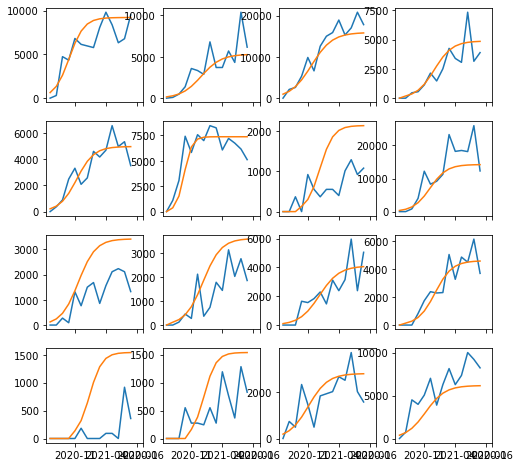

In [31]:
plotRandomEstimationRegions(regionYTrue['brand_1'], estimatesTrain['brand_1'])

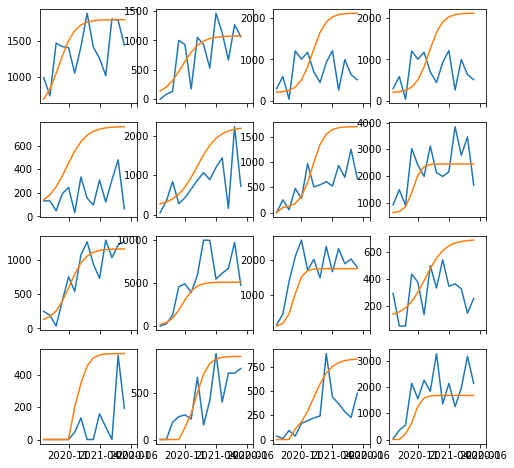

In [30]:
plotRandomEstimationRegions(regionYTrue['brand_2'], estimatesTrain['brand_2'])

In [7]:
estimatesSubmissionTrain.head()

,region,month,brand,sales
0,region_0,2020-07,brand_1,123.534910
1,region_0,2020-07,brand_2,0.000000
2,region_0,2020-08,brand_1,328.887748
3,region_0,2020-08,brand_2,101.500456
4,region_0,2020-09,brand_1,806.315310


In [8]:
# train correction model from estimates
estimatesMergedTrain = mergeTimeAndEstimatedData(estimatesSubmissionTrain, timeTrain)

In [9]:
correctionModels = trainCorrectionModel(estimatesMergedTrain, timeYTrue, modelType, modelParams)

In [10]:
correctionsTrain = predictCorrectionModel(estimatesMergedTrain, correctionModels)
ciBounds = getCIFromCorrectionModel(estimatesMergedTrain, correctionModels)
submissionData = makeCorrectionSubmissionData(correctionsTrain, ciBounds, True)

groundTruth = sales[sales['brand'].apply(filterBrands)][sales['month'].apply(filterMonths)]
score = ComputeMetrics(submissionData, 
                       sales, 
                       groundTruth)
score

/tmp/ipykernel_3118/3421740572.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  groundTruth = sales[sales['brand'].apply(filterBrands)][sales['month'].apply(filterMonths)]


(91.65718095023561, 449.78849217605324)

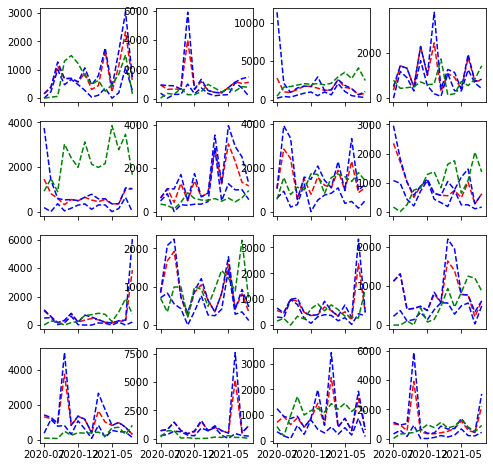

In [19]:
plotRandomRegions(submissionData, 'brand_2', True, groundTruth)

In [10]:
# load test data, predict test data, get submission data

regionTest = loadRegionData(False)
timeTest = loadTimeData(False)
salesTest = loadSalesData(False)

regionTest['brand_1'].shape, timeTest['brand_1'].shape, salesTest.shape

((50, 26), (700, 27), (3000, 4))

In [11]:
estimatesTest = predictEstimationModel(regionTest, models, scalers)
estimatesSubmissionTest = makeSubmissionDataFromEstimates(estimatesTest, False)

In [12]:
estimatesSubmissionTest.shape

(1400, 4)

In [13]:
estimatesSubmissionTest.tail()

,region,month,brand,sales
1395,region_200,2021-06,brand_2,1423.133309
1396,region_200,2021-07,brand_1,4130.603043
1397,region_200,2021-07,brand_2,1426.850506
1398,region_200,2021-08,brand_1,4135.442121
1399,region_200,2021-08,brand_2,1428.443439


In [14]:
estimatesMergedTest = mergeTimeAndEstimatedData(estimatesSubmissionTest, timeTest)

In [15]:
correctionsTest = predictCorrectionModel(estimatesMergedTest, correctionModels)
ciBounds = getCIFromCorrectionModel(estimatesMergedTest, correctionModels)

In [16]:
submissionData = makeCorrectionSubmissionData(correctionsTest, ciBounds)

In [17]:
submissionData.head(n=10)

,region,month,sales,lower,upper,brand
0,region_151,2020-07,2404.21366,367.460,3215.290,brand_1
1,region_151,2020-07,319.55858,105.238,534.020,brand_2
2,region_151,2020-08,2662.33570,183.730,5328.230,brand_1
3,region_151,2020-08,1690.94194,122.650,3979.930,brand_2
4,region_151,2020-09,1874.61736,0.000,3651.688,brand_1
5,region_151,2020-09,1027.61752,288.134,1561.090,brand_2
6,region_151,2020-10,3354.37554,2572.250,4225.840,brand_1
7,region_151,2020-10,1068.02856,211.060,1640.640,brand_2
8,region_151,2020-11,4084.97502,734.930,6522.340,brand_1
9,region_151,2020-11,1682.17356,231.740,3165.240,brand_2


In [18]:
submissionData.tail(n=10)

,region,month,sales,lower,upper,brand
1390,region_200,2021-04,2641.51120,673.68,3690.82,brand_1
1391,region_200,2021-04,1329.63708,203.29,2323.70,brand_2
1392,region_200,2021-05,1073.53706,0.00,1837.32,brand_1
1393,region_200,2021-05,1038.39934,566.76,1349.94,brand_2
1394,region_200,2021-06,3436.01104,538.95,5328.23,brand_1
1395,region_200,2021-06,1568.31950,450.59,2455.51,brand_2
1396,region_200,2021-07,976.42598,0.00,2021.05,brand_1
1397,region_200,2021-07,1038.04396,211.34,1103.05,brand_2
1398,region_200,2021-08,1927.02712,183.73,3031.58,brand_1
1399,region_200,2021-08,1582.17582,537.28,2323.70,brand_2


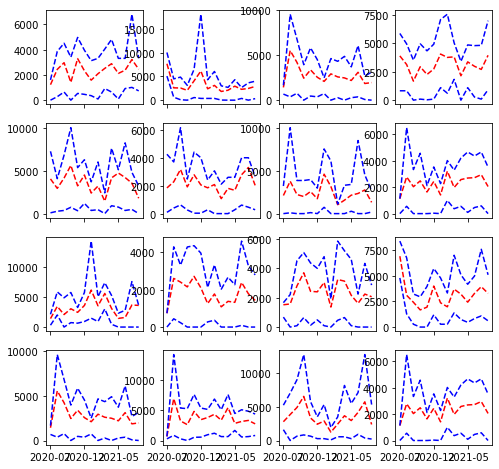

In [19]:
plotRandomRegions(submissionData, 'brand_1')

In [20]:
submissionData.to_csv('./data/data_files/submissions/sigmoid_rf_correction_model.csv', index=False)

In [19]:
base_metric?